<a href="https://colab.research.google.com/github/ZackAkil/optimising-basketball/blob/master/shot%20prediction/where_did_i_shoot_from.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [2]:
!gsutil ls gs://rugby-videos

gs://rugby-videos/VID_20181215_095232.mp4
gs://rugby-videos/deltas.joblib
gs://rugby-videos/deltas.mp4
gs://rugby-videos/model.h5
gs://rugby-videos/model.json
gs://rugby-videos/model_where.h5
gs://rugby-videos/model_where.json
gs://rugby-videos/output_320_full.mp4
gs://rugby-videos/y.joblib


In [3]:
!gsutil cp gs://rugby-videos/deltas.mp4 .

Copying gs://rugby-videos/deltas.mp4...
/ [1 files][  6.0 MiB/  6.0 MiB]                                                
Operation completed over 1 objects/6.0 MiB.                                      


In [4]:
!gsutil cp gs://rugby-videos/y.joblib .

Copying gs://rugby-videos/y.joblib...
/ [1 files][ 28.4 KiB/ 28.4 KiB]                                                
Operation completed over 1 objects/28.4 KiB.                                     


In [0]:
from sklearn.externals import joblib
from scipy.misc import imresize

In [0]:
ys = joblib.load('y.joblib')

In [0]:
!pip install scikit-video --quiet

In [0]:
from skvideo.io import vread
import numpy as np

In [0]:
X_delta = vread('deltas.mp4')[:,:,:,0]
X = np.expand_dims(X_delta, axis=3)[:7000]
del(X_delta)

In [0]:
# laod test data, making sure its from a different sequece completly

X_delta = vread('deltas.mp4')[:,:,:,0]
X_test = (np.expand_dims(X_delta, axis=3)[7000:]/ 255.).astype(np.float16)
del(X_delta)

# turn y coords in to a boolean flag for 'was a shot taken'
valid_test_y = ~(np.array(ys['y'][7000:]) == None)


y_test = np.zeros([len(valid_test_y), 2])
y_test[:,0] = np.array(ys['x'][7000:]) 
y_test[:,1] = np.array(ys['y'][7000:])
y_test = y_test[valid_test_y]

y_test[:,0] /= 320.
y_test[:,1] /= 180.

X_test= X_test[valid_test_y]

In [12]:
X.shape

(7000, 180, 320, 1)

In [0]:
# turn y coords in to a boolean flag for 'was a shot taken'
Valid_y = ~(np.array(ys['y'][:7000]) == None)

In [0]:
y = np.zeros([len(Valid_y), 2])
y[:,0] = np.array(ys['x'][:7000]) 
y[:,1] = np.array(ys['y'][:7000])
y = y[Valid_y]

# y[:,0] /= 320.
# y[:,1] /= 180.

In [43]:
y

array([[183., 109.],
       [183., 109.],
       [183., 109.],
       ...,
       [228., 110.],
       [228., 110.],
       [228., 110.]])

In [0]:
shot_x = X[Valid_y]

# Augment data
shift up and across X and y

In [45]:
y.min(axis=0), y.max(axis=0)

(array([173., 105.]), array([240., 116.]))

In [0]:
y_m = len(y)

In [16]:
x_trans = (np.arange(3)*20)-20
x_trans

array([-20,   0,  20])

In [64]:
y_trans = (np.arange(3)*15)-10
y_trans

array([-10,   5,  20])

In [65]:
new_data = np.zeros([(y_m*3)*4, 180, 320, 1]).astype(np.uint8)
new_y = np.zeros([(y_m*3)*4,2])
new_data.shape, new_y.shape

((8532, 180, 320, 1), (8532, 2))

In [66]:
# X axis translation augmentation 

for i, trans in enumerate(x_trans):
  from_index = i*y_m
  to_index = (i+1)*y_m
  print('writing {0} to {1}, translation of {2}'.format(from_index, to_index, trans))
  
  
  new_data[from_index:to_index] = np.roll(shot_x, trans)
  print(new_data.sum())
  
  new_y[from_index:to_index, 0] = y[:,0] + trans
  new_y[from_index:to_index, 1] = y[:,1]
  
  print('traslated y {0}'.format(new_y.sum()))

writing 0 to 711, translation of -20
727378894
traslated y 212874.0
writing 711 to 1422, translation of 0
1454757788
traslated y 439968.0
writing 1422 to 2133, translation of 20
2182136682
traslated y 681282.0


In [67]:
# X axis translation augmentation 

offset = 2133

starting_data = new_data[:offset]
starting_y = new_y[:offset]

for i, trans in enumerate(y_trans):
  
  from_index = (i*offset) + offset
  to_index = ((i+1)*offset) + offset
  print('writing {0} to {1}, translation of {2}'.format(from_index, to_index, trans))
  
  
  new_data[from_index:to_index] = np.roll(starting_data, trans, axis=1)
  print(new_data.sum())
  
  new_y[from_index:to_index, 1] = starting_y[:,1] + trans
  new_y[from_index:to_index, 0] = starting_y[:,0]
  
  print('traslated y {0}'.format(new_y.sum()))

writing 2133 to 4266, translation of -10
4364273364
traslated y 1341234.0
writing 4266 to 6399, translation of 5
6546410046
traslated y 2033181.0
writing 6399 to 8532, translation of 20
8728546728
traslated y 2757123.0


In [36]:
y.shape, X.shape

((711, 2), (7000, 180, 320, 1))

In [68]:
new_y.min(axis=0), new_y.max(axis=0)

(array([153.,  95.]), array([260., 136.]))

In [0]:
new_y[:,0] /= 320.
new_y[:,1] /= 180.

In [0]:
import matplotlib.pyplot as plt

In [0]:
def show_random_frames(X, y):
  
  random_indexes = np.random.choice(range(len(y)), 5)

  # confirm that our y match with frames with shots
  for index in random_indexes:
    
    plt.imshow(X[index])
    plt.axvline(y[index, 0]*320)
    plt.axhline(y[index, 1]*180)
    plt.show()

In [42]:
new_y

array([[163.,   0.],
       [163.,   0.],
       [163.,   0.],
       ...,
       [  0.,   0.],
       [  0.,   0.],
       [  0.,   0.]])

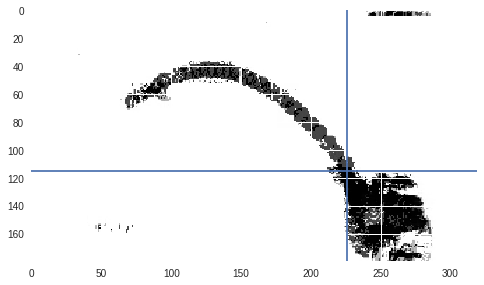

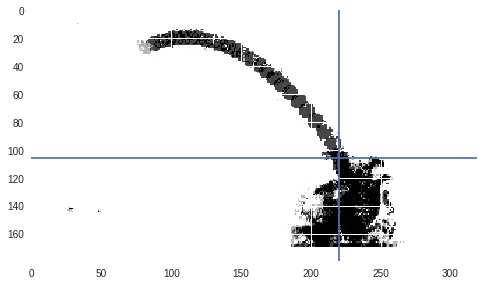

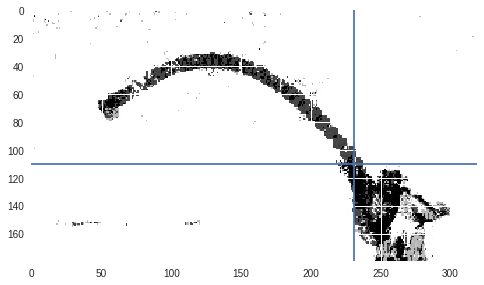

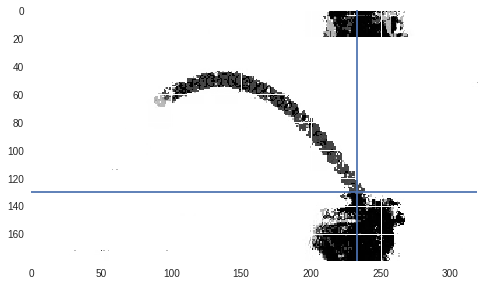

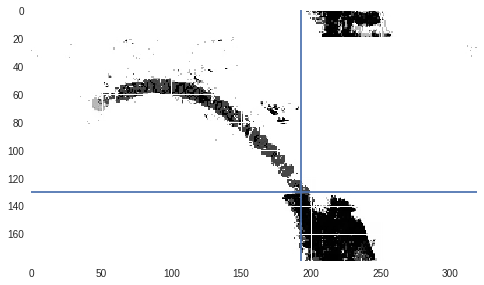

In [78]:
show_random_frames(new_data[:,:,:,0], new_y)

In [0]:
from sklearn.model_selection import train_test_split

In [74]:
new_y.shape

(8532, 2)

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=42)

In [0]:
X_train = new_data
y_train = new_y

In [0]:
del(X)

In [0]:
X_train = (X_train / 255.).astype(np.float16)
X_test = (X_test / 255.).astype(np.float16)

In [85]:
X_test.dtype

dtype('float16')

In [86]:
y.shape

(711, 2)

In [87]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [88]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
X.shape

(1239, 180, 320, 1)

In [0]:
input_shape = (180, 320, 1)

In [0]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# model.add(Conv2D(4, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='linear'))

In [0]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam())

In [114]:
y_train.shape, X_train.shape

((8532, 2), (8532, 180, 320, 1))

In [115]:
y_test.shape, X_test.shape

((528, 2), (528, 180, 320, 1))

In [120]:
batch_size = 128
epochs = 5


model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 8532 samples, validate on 528 samples
Epoch 1/5
8532/8532 [==============================] - 8s 909us/step - loss: 0.0040 - val_loss: 0.0044
Epoch 2/5
8532/8532 [==============================] - 8s 893us/step - loss: 0.0039 - val_loss: 0.0044
Epoch 3/5
8532/8532 [==============================] - 8s 895us/step - loss: 0.0038 - val_loss: 0.0044
Epoch 4/5
8532/8532 [==============================] - 8s 891us/step - loss: 0.0039 - val_loss: 0.0044
Epoch 5/5
8532/8532 [==============================] - 8s 894us/step - loss: 0.0039 - val_loss: 0.0044


In [0]:
def gray_to_channel(image):
  new_image = np.zeros([*image.shape[:2], 3])
  new_image[:,:,0] = image.reshape(image.shape[:2])
  new_image[:,:,1] = image.reshape(image.shape[:2])
  new_image[:,:,2] = image.reshape(image.shape[:2])
  return new_image

In [0]:
def show_frames(X, y, m=10):
  print(X.shape, y.shape)
  

  for i in range(m):
    
    plt.imshow(gray_to_channel(X[i]))
    plt.axvline(y[i, 0]*320)
    plt.axhline(y[i, 1]*180)
    plt.grid(False)
    plt.show()

In [105]:
y_test

array([[0.5625    , 0.61111111],
       [0.5625    , 0.61111111],
       [0.5625    , 0.61111111],
       ...,
       [0.5       , 0.62777778],
       [0.5       , 0.62777778],
       [0.5       , 0.62777778]])

(53, 180, 320, 1) (53, 2)


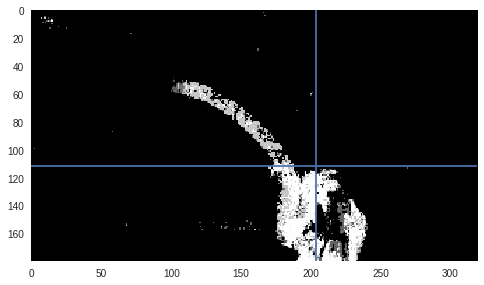

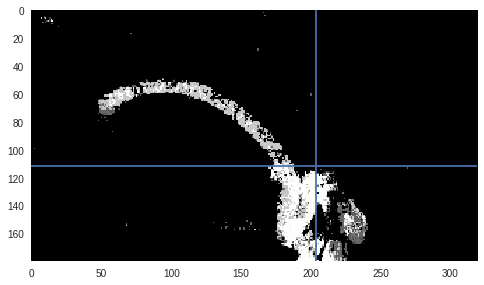

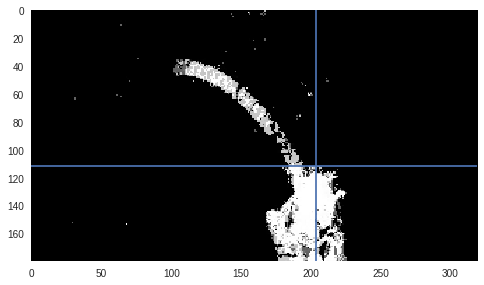

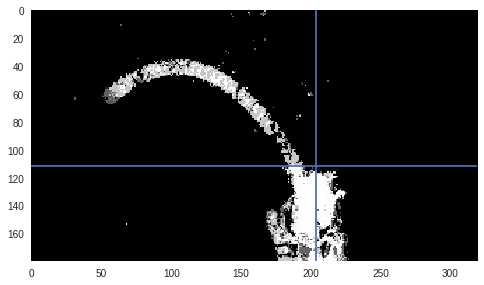

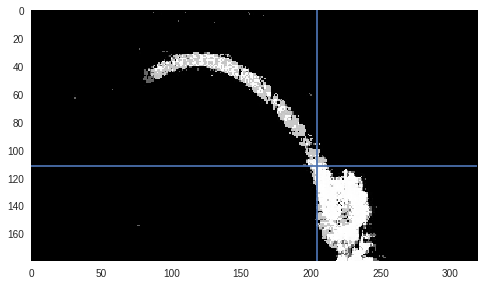

In [121]:
pred = model.predict(X_test)
show_frames(X_test[::10], pred[::10], m=5)

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [122]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

Saved model to disk


In [123]:
! gsutil cp model.h5 gs://rugby-videos/model_where.h5

Copying file://model.h5 [Content-Type=application/octet-stream]...
/ [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      


In [124]:
! gsutil cp model.json gs://rugby-videos/model_where.json

Copying file://model.json [Content-Type=application/json]...
/ [1 files][  2.2 KiB/  2.2 KiB]                                                
Operation completed over 1 objects/2.2 KiB.                                      


In [125]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 178, 318, 4)       40        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 159, 4)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 89, 159, 4)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 56604)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 452840    
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
Total para